## <font color = "red">概要</font>
notebook_name：nb05<br>
kaggle dataset：<br>
kaggle notebook：kagglenb004<br>
Summary：[Ubiquant Market Prediction with DNN](https://www.kaggle.com/lonnieqin/ubiquant-market-prediction-with-dnn/notebook)のモデル流用<br>
early stopping = 10　にして過学習気味に
<br>
CV： 
<br>
PL：


## <font color = "red">初期設定</font>

In [1]:
# Google Colaboratory上からGoogle Drive上のファイルにアクセスできるようにする
from google.colab import drive
drive.mount('/content/drive')

# ~/.kaggleディレクトリを作成し、ここへDrive上のkaggle.jsonをコピーしてくる
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定（所有者⇒フル権限・その他無し）
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [2]:
#ライブラリのインストール
!pip install kaggle                     #kaggleAPI利用用

!pip install tensorflow==2.6.2          #kaggle版のtensorflowとバージョン条件を合わせる

!pip install lightgbm==3.3.1            #kaggle版のlightgbmとバージョン条件を合わせる

!pip install japanize-matplotlib        #matplotlibの日本語対応

!pip install pandas==1.3.4

     |████████████████████████████████| 458.3 MB 10 kB/s 
     |████████████████████████████████| 132 kB 75.4 MB/s 
     |████████████████████████████████| 1.3 MB 63.3 MB/s 
     |████████████████████████████████| 5.6 MB 46.8 MB/s 
     |████████████████████████████████| 462 kB 76.9 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=70076f9cbf11b9c51941a6f66e2df7554066086ab43c8d04b3897b78342c0e81
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68726 sha256=26ba75a318d0430c825d36060d4f4b634dc53f28153f5c3fa18f234b723db1c4
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built clang wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Succes

In [3]:
%%time
#kaggleから"ubiquant-parquet"を保存
!kaggle datasets download -d robikscube/ubiquant-parquet -p /content
!kaggle datasets download -d lonnieqin/ubiquant-market-prediction-half-precision-pickle

100% 12.5G/12.5G [01:41<00:00, 150MB/s]
100% 12.5G/12.5G [01:41<00:00, 132MB/s]
 99% 1.44G/1.46G [00:10<00:00, 153MB/s]
100% 1.46G/1.46G [00:11<00:00, 141MB/s]
CPU times: user 1.68 s, sys: 644 ms, total: 2.32 s
Wall time: 1min 54s


In [4]:
%%time
#解凍用パス
import zipfile
with zipfile.ZipFile('/content/ubiquant-parquet.zip') as existing_zip:
    existing_zip.extractall('/content')
with zipfile.ZipFile('/content/ubiquant-market-prediction-half-precision-pickle.zip') as existing_zip:
    existing_zip.extractall('/content')



CPU times: user 2min 47s, sys: 23.1 s, total: 3min 10s
Wall time: 3min 55s


In [5]:
#Import
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
import tensorflow as tf

#フォルダ/ファイル操作用
import shutil

#tensorflow INFO/WARNING削除
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import warnings
warnings.filterwarnings('ignore')

tf.get_logger().setLevel("ERROR")

tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

import logging
tf.get_logger().setLevel(logging.ERROR)

## <font color = "red">parquet datasetsの読み込み</font>

In [6]:
#%%time
#Pathの設定
DATA_PATH = '/content/'
#train = pd.read_parquet(DATA_PATH + 'train.parquet') 
train = pd.read_pickle(DATA_PATH + 'train.pkl')

n_features = 300
features = [f'f_{i}' for i in range(n_features)]

In [7]:
train.head()

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,...,f_261,f_262,f_263,f_264,f_265,f_266,f_267,f_268,f_269,f_270,f_271,f_272,f_273,f_274,f_275,f_276,f_277,f_278,f_279,f_280,f_281,f_282,f_283,f_284,f_285,f_286,f_287,f_288,f_289,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,0.114807,-2.013672,0.004936,0.284180,0.501953,-0.287842,-1.168945,-0.267334,-0.574219,-0.771973,1.012695,-1.230469,1.786133,-2.089844,0.325684,-0.877930,1.048828,0.131714,-0.349609,-1.813477,0.099243,-0.240967,1.604492,0.003637,-0.901855,0.221558,0.609863,-0.738770,2.097656,-0.914062,...,0.709473,-0.031891,-1.020508,-1.291016,0.038666,0.187134,-0.680176,0.900391,-0.924805,-1.057617,-0.167114,0.0,1.281250,0.258789,-0.237915,-0.742188,-0.324707,0.992676,0.961426,-0.025604,-0.006260,0.473633,0.040131,0.453613,-1.597656,0.301758,0.157471,0.416748,1.505859,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,0.114807,-0.219238,-0.351807,0.846680,0.440186,0.499756,0.893066,-0.010216,-0.681641,1.253906,-1.027344,-1.690430,0.011154,0.875488,0.325684,-0.458252,-1.797852,-0.300293,0.584961,0.551270,0.806641,1.235352,-0.984863,-1.084961,3.162109,0.211060,-2.656250,-0.177002,0.486572,1.237305,...,-0.015457,-0.158325,0.980469,0.799316,0.798340,-0.633301,0.779785,0.171265,1.166016,0.590820,0.118530,0.0,-0.650879,0.852051,0.086182,1.135742,0.299072,-1.583008,-0.481934,0.532227,0.226685,-0.894531,-0.514648,-1.000000,0.884277,-0.557617,-0.875488,-0.156128,0.537109,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079
2,6,0,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,0.114807,-1.035156,0.465088,0.150879,-0.044006,0.091248,-1.168945,-0.451904,-0.467285,0.095276,1.140625,-0.166870,-0.007294,-0.449463,0.325684,-0.682617,0.016266,0.026123,-0.547363,0.551270,-0.261475,-0.169678,0.857422,-0.098450,-0.860352,0.180176,0.609863,0.524902,-0.400391,0.751465,...,-0.528320,0.189453,-1.020508,0.169678,-0.911133,-0.222046,0.536621,-0.161743,-0.114319,0.433350,-0.207153,0.0,0.098938,-0.725098,-0.388184,0.062622,0.260254,0.980957,0.899414,-0.315430,0.150146,0.245605,-1.429688,-1.000000,-0.033508,-0.147095,-0.087524,0.098450,-0.528809,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652,0.568848
3,7,0,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,0.114807,-1.176758,0.301270,-0.015671,-0.656250,-0.150879,-1.168945,-1.122070,-0.681641,2.921875,1.179688,0.364014,0.365723,-1.478516,0.325684,0.955566,-0.105042,-0.588867,0.649902,-1.813477,-1.421875,1.526367,-0.054657,-0.345459,0.259277,0.124939,-0.478760,-0.457764,-0.072266,0.577637,...,0.084229,-0.836426,-1.020508,1.272461,-0.667969,-1.452148,1.168945,-1.025391,-0.924805,1.013672,-0.324463,0.0,-0.817871,-0.624023,0.012917,0.599121,-1.795898,-1.843750,2.927734,-0.640625,2.324219,-0.666504,-0.049957,-1.000000,-0.172485,-0.557617,-0.986816,-0.744629,0.237793,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438,-1.064453
4,8,0,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,0.114807,-0.005859,0.498779,-0.235474,-0.173340,0.106506,-0.138062,-0.829102,-0.826172,4.070312,0.148315,0.269531,-0.046692,0.194336,0.325684,1.933594,-1.120117,-0.585449,0.535645,0.551270,-0.770996,0.216187,0.022415,-0.924316,0.198120,0.232422,-1.567383,-0.317383,-1.020508,0.079224,...,-1.657227,-0.875000,0.980469,0.778809,-0.916504,-0.556152,0.925781,-1.507812,1.166016,0.941406,-0.501465,0.0,-1.333008,-0.767578,-0.237915,0.330811,-1.464844,-0.585449,-1.314453,-0.781250,-1.

## <font color = "red">データの分離</font>

In [8]:
investment_id = train.pop("investment_id")  #investmenmt_id列を分離
investment_id.head()

0    1
1    2
2    6
3    7
4    8
Name: investment_id, dtype: uint16

In [9]:
_ = train.pop("time_id")    #time_id列を分離

In [10]:
y = train.pop("target")     #target列を分離
y.head()

0   -0.300781
1   -0.231079
2    0.568848
3   -1.064453
4   -0.531738
Name: target, dtype: float16

## <font color = "red">Create a IntegerLookup layer for investment_id input</font>
[公式Document](https://www.tensorflow.org/api_docs/python/tf/keras/layers/IntegerLookup)
<br>
特徴：このレイヤーは、任意の整数の配列を、語彙検索(lookup)によって配列のuniqueな整数の個数を最大値とする連続した整数出力にする。out-of-vocabulary (OOV) トークン（要素）とマスキングをオプションでサポートしている。
<br>
ex)
<br>今回は②の手法でinvestment_idを1～3580（investment_idのuniqueな個数）に変換
<br><br>
# ①vocabデータを指定して利用<br>
vocab：<font color="yellow">[12, 1138, 42, 38 2, 1000]
</font><br>
入力データ：<font color="yellow">[42, 1000, 1500, 38, 320, 42, 1138, 12]</font>
<br>
出力データ：<font color="yellow">[3, 6, 0, 4, 0, 3, 2, 1]</font>
<br>
  ※vocabの何要素目の値かが出力データとなる

# ②vocabデータを学習して利用<br>
学習用vocab：<font color="yellow">[12, 1138, 42, 42, 38 2, 1000]</font>
<br>
学習したvocab：<font color="yellow">[-1, 42, 1138, 1000, 38, 12, 2]</font>
<br>
  ※逆順にuniqueな値を格納。先頭に、OOV用の-1がセット。
  <br>
    その後は頻出順＆降順  
入力データ：<font color="yellow">[2, 42, 1000, 500, -1, 6, 12]</font>
<br>
出力データ：<font color="yellow">[6, 1, 3, 0, 0, 0, 5]</font>
  ※vocabにないデータは全て0に。


In [11]:
%%time
investment_ids = list(investment_id.unique())         #investment_idのユニークな値のリスト作成
investment_id_size = len(investment_ids) + 1          #investment_idのサイズ数を保持
investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)  #空のlookup_layer作成＆サイズマックスとしてinvestment_idの個数を指定
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids":investment_ids})) #lookup_layerでvocabulary作成。
print(investment_id_lookup_layer.vocab_size())    #作成したvocabularyの確認。uniqueなinvestment_idのリストになっている。このvocabularyを作成してlookup（investment_idの値を1～len(investment_id)+1の連続値に変換）を実行する。

3580
CPU times: user 348 ms, sys: 50 ms, total: 398 ms
Wall time: 597 ms


## <font color = "red">Make Tensorflow dataset</font><br>


In [12]:
def preprocess(X, y):
    return X, y
def make_dataset(feature, investment_id, y, batch_size=1024, mode="train"):      #引数としてfeature, investment_id, y(ラベル)を別個で入力。modeの入力によって場合分け。
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))       #tf形式のデータセットにするのみ。データの結合はせず、並べたのみ。
    ds = ds.map(preprocess)                                                      #proprocessの内容をdsに適用。ここ必要なのかな？？？処理前後で変化がない。
    if mode == "train":
        ds = ds.shuffle(4096, seed=100, reshuffle_each_iteration=False)          #'4096'はbuffer。正確ではないが、イメージ的には最初の4096個の要素内でシャッフルが行われ、次の4096個という順。seed値を指定。また、iterateの度に順が変わらないように設定。
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)    #batch_sizeの個数のデータに分割。cacheでデータを固定。iterateの度に値が変わることを避ける。prefetchは、動的に事前読み込みを行うことで処理を高速化する。
    return ds

In [13]:
#tf.datasetの要素の確認方法
"""
dataset = tf.data.Dataset.from_tensor_slices([1.0, 2, 3])
dataset = dataset.map(lambda x: x*2)
for element in dataset:         #各要素の形式を表示
  print(element)
list(dataset.as_numpy_iterator()) #datasetの内容を一つずつnp形式で取り出すのがiterator。取り出したものをlistに格納している。
"""

'\ndataset = tf.data.Dataset.from_tensor_slices([1.0, 2, 3])\ndataset = dataset.map(lambda x: x*2)\nfor element in dataset:         #各要素の形式を表示\n  print(element)\nlist(dataset.as_numpy_iterator()) #datasetの内容を一つずつnp形式で取り出すのがiterator。取り出したものをlistに格納している。\n'

In [14]:
#df.shuffleの設定値確認
"""
investment_id_short = investment_id.head(100)
train_short = investment_id.head(100)
y_short = y.head(100)

def preprocess(X, y):
    return X, y

ds = tf.data.Dataset.from_tensor_slices(((investment_id_short, train_short), y_short))
ds = ds.map(preprocess)
ds = ds.shuffle(5, seed=100, reshuffle_each_iteration=False)
#for element in ds:
#  print(element)
#print(train_short.head())
"""

'\ninvestment_id_short = investment_id.head(100)\ntrain_short = investment_id.head(100)\ny_short = y.head(100)\n\ndef preprocess(X, y):\n    return X, y\n\nds = tf.data.Dataset.from_tensor_slices(((investment_id_short, train_short), y_short))\nds = ds.map(preprocess)\nds = ds.shuffle(5, seed=100, reshuffle_each_iteration=False)\n#for element in ds:\n#  print(element)\n#print(train_short.head())\n'

## <font color = "red">Modeling</font>
[記述方法（Functional API）](https://www.tensorflow.org/guide/keras/functional?hl=en)
<br>
model_特徴：f.keras.Sequential APIよりも柔軟なモデルを作成するための方法です。
<br>
[tf.Keras.Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input?hl=en)
<br>
[tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding?hl=en)
<br>
[tf.keras.layers.Reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape?hl=en)
<br>
[tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
<br>
[tf.keras.layers.concatenate](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate)
<br>
[tf.keras.Model compile()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)


In [15]:
def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)               #入力の形状指定。形式は(data_size, batch_size)。バッチサイズは常に省略表示。
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)                 #入力の形状指定。形式は(data_size, batch_size)。バッチサイズは常に省略表示。
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)          #investment_idを1～3580（investment_idのuniqueな個数）に変換。未知なものは-1を入れる。batch_size=1024を適用。
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x) #(input,output,input_length)->investment_idを32次元のデータに変換
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)                   #-1は自動設定。入：TensorShape([None, 1, 32])　出：TensorShape([None, 32])　フラット化？
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)     
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)          #256で出力。活性化関数をswish
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])                #investment_id, feature_xのノードをそれぞれ統合
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)       #L2正則化項を損失関数のペナルティに加えることで過学習を抑制
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse', metrics=['mse', "mae", "mape", rmse])   #Adam(学習率0.01)を採用。損失関数をmse。評価関数に主要なものを一式。
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        114560      integer_lookup[0][0]             
__________________________________________________________________________________________________
reshape (Reshape)               (None, 32)           0           embedding[0][0]                  
______________________________________________________________________________________________

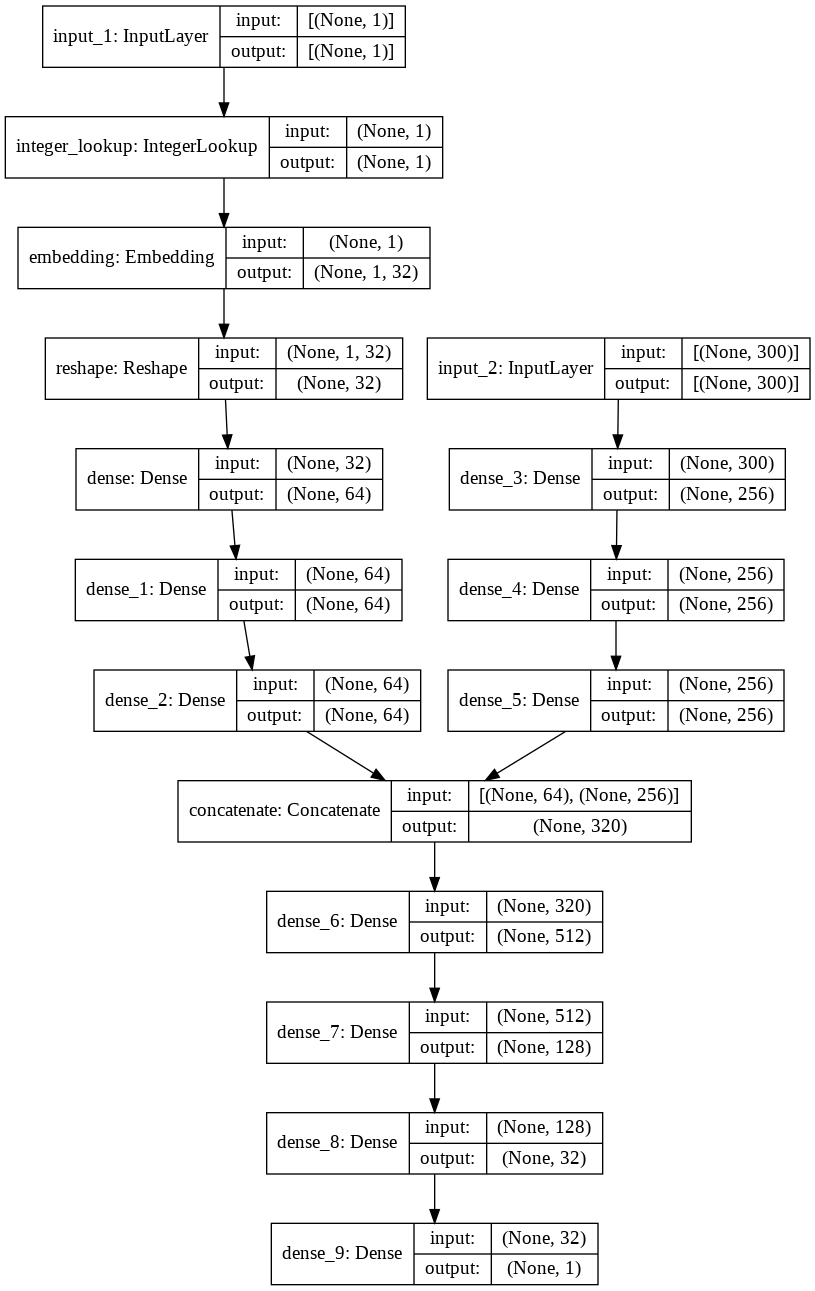

In [16]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## <font color = "red">Training</font>
[tf.keras.callbacks.ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint?hl=en)
<br>
[tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?hl=en)
<br>
[tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?hl=en)
<br>
[tf.keras.Model.fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model?hl=en#fit)
<br>
[tf.keras.models.load_model](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model?hl=en)
<br>
[]()

In [17]:
#pearsonグラフ作成用関数
def make_pearson_graph(y_true, y_pred, pearson_score):
  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)
  ax.scatter(y_true, y_pred, alpha=0.2, s=50, c='red')
  ax.set_xlabel('y_true')
  ax.set_ylabel('y_pred')
  ax.set_title('Pearson_val:' + str(pearson_score))
  plt.show()

--------------Fold(train):0--------------
Epoch 1/50
2455/2455 [==============================] - 250s 101ms/step - loss: 0.9095 - mse: 0.8312 - mae: 0.6243 - mape: 123810.8984 - rmse: 0.9117 - val_loss: 0.8412 - val_mse: 0.8396 - val_mae: 0.6292 - val_mape: 196785.2812 - val_rmse: 0.9163
Epoch 2/50
2455/2455 [==============================] - 503s 205ms/step - loss: 0.8307 - mse: 0.8271 - mae: 0.6230 - mape: 143382.5625 - rmse: 0.9095 - val_loss: 0.8393 - val_mse: 0.8378 - val_mae: 0.6298 - val_mape: 157616.2344 - val_rmse: 0.9153
Epoch 3/50
2455/2455 [==============================] - 604s 246ms/step - loss: 0.8295 - mse: 0.8245 - mae: 0.6218 - mape: 150585.4219 - rmse: 0.9080 - val_loss: 0.8390 - val_mse: 0.8373 - val_mae: 0.6293 - val_mape: 164288.5781 - val_rmse: 0.9150
Epoch 4/50
2455/2455 [==============================] - 610s 249ms/step - loss: 0.8275 - mse: 0.8223 - mae: 0.6209 - mape: 148998.5938 - rmse: 0.9068 - val_loss: 0.8376 - val_mse: 0.8360 - val_mae: 0.6291 - val_map

--------------Fold(result):0--------------
Pearson_score: 0.1277001890862083
Pearson_score_p_value: 0.0


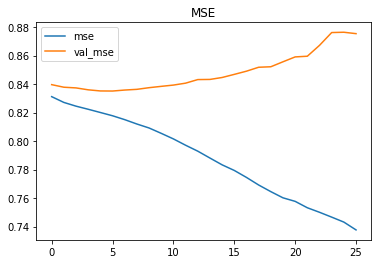

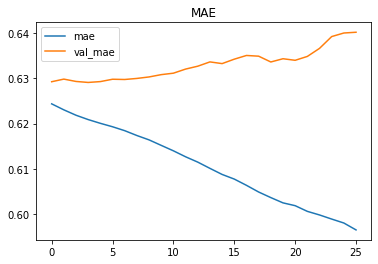

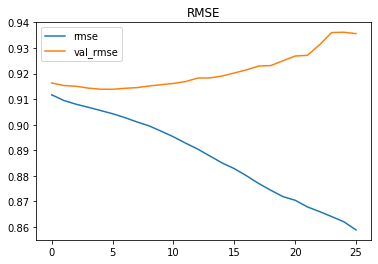

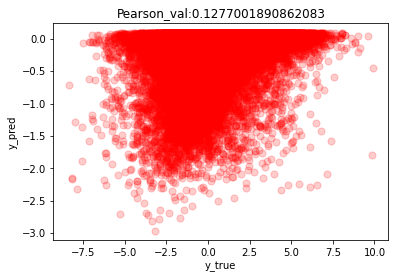

--------------Fold(train):1--------------
Epoch 1/50
2455/2455 [==============================] - 83s 33ms/step - loss: 0.9109 - mse: 0.8323 - mae: 0.6248 - mape: 122565.5156 - rmse: 0.9123 - val_loss: 0.8377 - val_mse: 0.8360 - val_mae: 0.6277 - val_mape: 154146.9688 - val_rmse: 0.9143
Epoch 2/50
2455/2455 [==============================] - 465s 189ms/step - loss: 0.8316 - mse: 0.8272 - mae: 0.6228 - mape: 145714.4375 - rmse: 0.9095 - val_loss: 0.8355 - val_mse: 0.8338 - val_mae: 0.6263 - val_mape: 176428.9531 - val_rmse: 0.9131
Epoch 3/50
2455/2455 [==============================] - 394s 160ms/step - loss: 0.8294 - mse: 0.8240 - mae: 0.6216 - mape: 152394.1250 - rmse: 0.9077 - val_loss: 0.8358 - val_mse: 0.8337 - val_mae: 0.6274 - val_mape: 151980.6562 - val_rmse: 0.9131
Epoch 4/50
2455/2455 [==============================] - 466s 190ms/step - loss: 0.8281 - mse: 0.8217 - mae: 0.6206 - mape: 150292.0156 - rmse: 0.9065 - val_loss: 0.8350 - val_mse: 0.8325 - val_mae: 0.6274 - val_mape:

--------------Fold(result):1--------------
Pearson_score: 0.1254876004444798
Pearson_score_p_value: 0.0


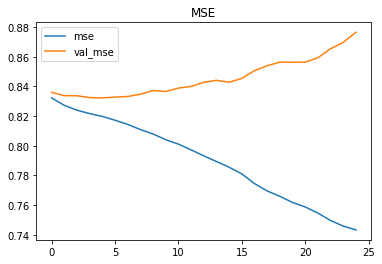

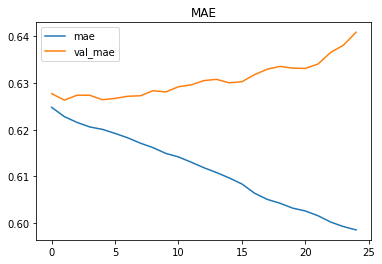

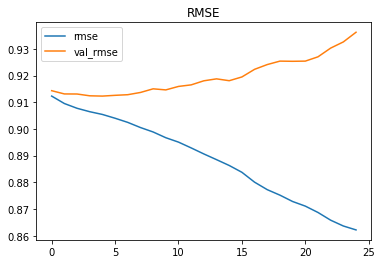

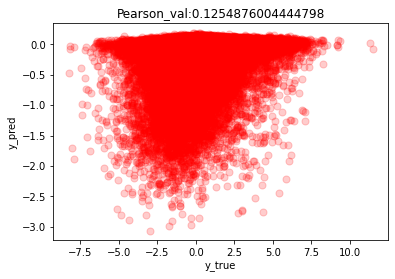

--------------Fold(train):2--------------
Epoch 1/50
2455/2455 [==============================] - 56s 23ms/step - loss: 0.9118 - mse: 0.8313 - mae: 0.6244 - mape: 118422.7891 - rmse: 0.9118 - val_loss: 0.8415 - val_mse: 0.8400 - val_mae: 0.6301 - val_mape: 139319.0000 - val_rmse: 0.9165
Epoch 2/50
2455/2455 [==============================] - 56s 23ms/step - loss: 0.8306 - mse: 0.8268 - mae: 0.6230 - mape: 136249.7656 - rmse: 0.9093 - val_loss: 0.8392 - val_mse: 0.8380 - val_mae: 0.6298 - val_mape: 146714.3438 - val_rmse: 0.9154
Epoch 3/50
2455/2455 [==============================] - 49s 20ms/step - loss: 0.8288 - mse: 0.8250 - mae: 0.6222 - mape: 132819.2812 - rmse: 0.9083 - val_loss: 0.8378 - val_mse: 0.8362 - val_mae: 0.6278 - val_mape: 159755.7031 - val_rmse: 0.9144
Epoch 4/50
2455/2455 [==============================] - 52s 21ms/step - loss: 0.8279 - mse: 0.8225 - mae: 0.6210 - mape: 136736.0312 - rmse: 0.9069 - val_loss: 0.8386 - val_mse: 0.8365 - val_mae: 0.6298 - val_mape: 13815

--------------Fold(result):2--------------
Pearson_score: 0.13272885731541242
Pearson_score_p_value: 0.0


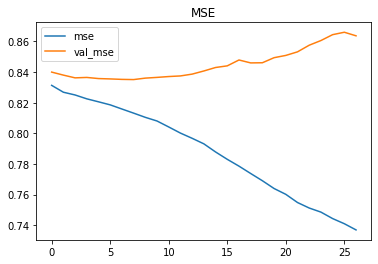

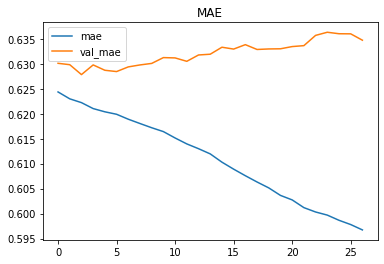

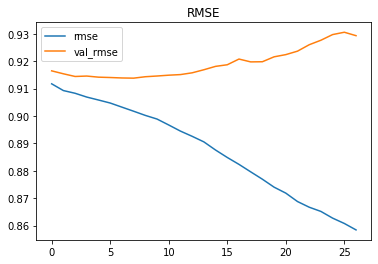

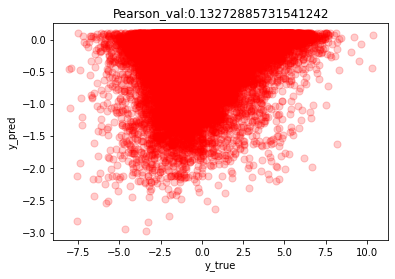

--------------Fold(train):3--------------
Epoch 1/50
2455/2455 [==============================] - 48s 19ms/step - loss: 0.9099 - mse: 0.8318 - mae: 0.6247 - mape: 127549.8828 - rmse: 0.9120 - val_loss: 0.8407 - val_mse: 0.8393 - val_mae: 0.6299 - val_mape: 154262.5156 - val_rmse: 0.9162
Epoch 2/50
2455/2455 [==============================] - 70s 29ms/step - loss: 0.8308 - mse: 0.8278 - mae: 0.6234 - mape: 141072.7344 - rmse: 0.9098 - val_loss: 0.8415 - val_mse: 0.8391 - val_mae: 0.6291 - val_mape: 186739.2344 - val_rmse: 0.9160
Epoch 3/50
2455/2455 [==============================] - 69s 28ms/step - loss: 0.8295 - mse: 0.8252 - mae: 0.6223 - mape: 141154.5312 - rmse: 0.9084 - val_loss: 0.8399 - val_mse: 0.8377 - val_mae: 0.6280 - val_mape: 204189.2188 - val_rmse: 0.9153
Epoch 4/50
2455/2455 [==============================] - 69s 28ms/step - loss: 0.8281 - mse: 0.8219 - mae: 0.6209 - mape: 142764.3594 - rmse: 0.9066 - val_loss: 0.8402 - val_mse: 0.8373 - val_mae: 0.6289 - val_mape: 20350

--------------Fold(result):3--------------
Pearson_score: 0.12137508803227423
Pearson_score_p_value: 0.0


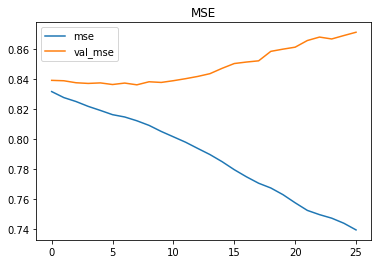

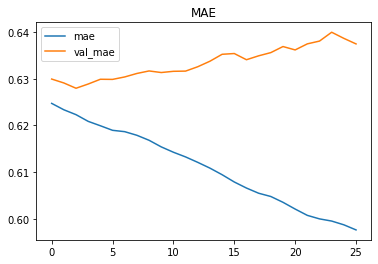

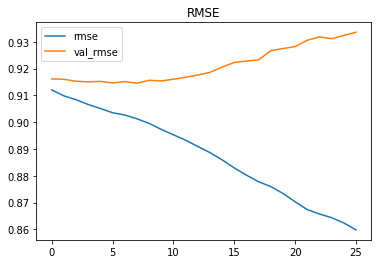

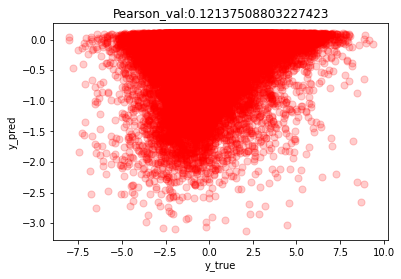

--------------Fold(train):4--------------
Epoch 1/50
2455/2455 [==============================] - 50s 20ms/step - loss: 0.9121 - mse: 0.8339 - mae: 0.6255 - mape: 125606.6562 - rmse: 0.9132 - val_loss: 0.8328 - val_mse: 0.8316 - val_mae: 0.6253 - val_mape: 210191.7500 - val_rmse: 0.9119
Epoch 2/50
2455/2455 [==============================] - 63s 26ms/step - loss: 0.8327 - mse: 0.8288 - mae: 0.6234 - mape: 149033.8438 - rmse: 0.9104 - val_loss: 0.8311 - val_mse: 0.8301 - val_mae: 0.6252 - val_mape: 205379.7656 - val_rmse: 0.9111
Epoch 3/50
2455/2455 [==============================] - 69s 28ms/step - loss: 0.8314 - mse: 0.8264 - mae: 0.6224 - mape: 151804.6094 - rmse: 0.9090 - val_loss: 0.8310 - val_mse: 0.8295 - val_mae: 0.6254 - val_mape: 183237.0625 - val_rmse: 0.9108
Epoch 4/50
2455/2455 [==============================] - 76s 31ms/step - loss: 0.8296 - mse: 0.8236 - mae: 0.6213 - mape: 145950.8438 - rmse: 0.9075 - val_loss: 0.8301 - val_mse: 0.8287 - val_mae: 0.6252 - val_mape: 17198

--------------Fold(result):4--------------
Pearson_score: 0.12312958329520125
Pearson_score_p_value: 0.0


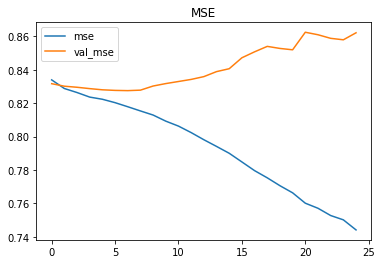

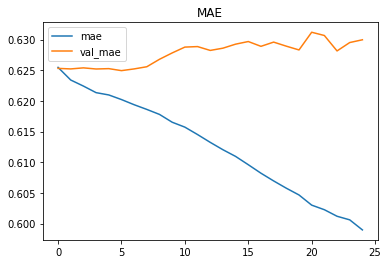

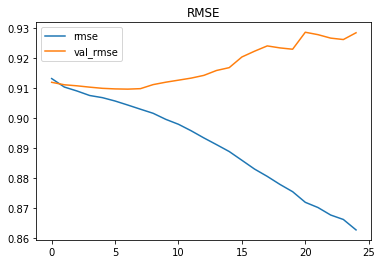

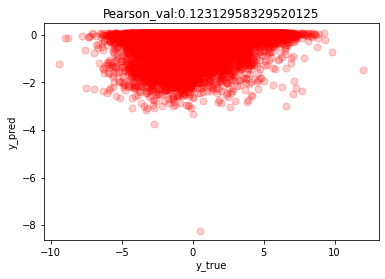

--------------Total Result--------------
Average_Pearson_score: 0.1260842636347152
CPU times: user 22h 13min 2s, sys: 10h 4min 59s, total: 1d 8h 18min 2s
Wall time: 6h 55min 22s


In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(5, shuffle=True, random_state=42)                       #5foldでtrain
models = []                                                                     #modelの保管場所
pearson_scores = []                                                             #CV値の保管場所
for index, (train_indices, valid_indices) in enumerate(kfold.split(train, investment_id)):  #foldのindexを取得 
    print('--------------'+"Fold(train):" + str(index)+'--------------') 
    X_train, X_val = train.iloc[train_indices], train.iloc[valid_indices]       #X_train, X_valを作成
    investment_id_train = investment_id[train_indices]                          #investment_id_trainを作成
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]               #目的関数を作成
    investment_id_val = investment_id[valid_indices]                            #investment_id_valを作成
    train_ds = make_dataset(X_train, investment_id_train, y_train)              #train用datasetの作成
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")      #val用datasetの作成
    model = get_model()                                                         #モデルの形成
    checkpoint = keras.callbacks.ModelCheckpoint(f"model_{index}", save_best_only=True)   #学習のepoch毎に、ベストのモデルのみ保存。content直下？
    early_stop = keras.callbacks.EarlyStopping(patience=20)                               #10epoch連続でmetricが良化しない場合、学習を止める。
    history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=[checkpoint, early_stop])    #fitの実施
    model = keras.models.load_model(f"model_{index}")                           #モデルのロード
    models.append(model)                                                        #モデルの保管
    
    y_pred = model.predict(valid_ds).ravel()                                    #np.ndarrayに形式を統一
    y_true = y_val.values                                                        #np.ndarrayに形式を統一
    pearson_score = stats.pearsonr(y_pred, y_true)[0]  #p値の算出。ravel()は１次元np配列への変換処理。
    pearson_scores.append(pearson_score)
    pearson_score_p_value = stats.pearsonr(y_pred, y_true)[1]  #p値の有意差の確認

    print('--------------'+'Fold(result):'+str(index)+'--------------')
    print('Pearson_score:', pearson_score)
    print('Pearson_score_p_value:',pearson_score_p_value)
    pd.DataFrame(history.history, columns=["mse", "val_mse"]).plot()
    plt.title("MSE")
    plt.show()
    pd.DataFrame(history.history, columns=["mae", "val_mae"]).plot()
    plt.title("MAE")
    plt.show()
    pd.DataFrame(history.history, columns=["rmse", "val_rmse"]).plot()
    plt.title("RMSE")
    plt.show()
    make_pearson_graph(y_true, y_pred, pearson_score)
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    del y_pred
    del y_true
    gc.collect()
    #break
print('--------------Total Result--------------')
print('Average_Pearson_score:', np.mean(pearson_scores))

In [ ]:
models

## <font color = "red">Upload for Kaggle dataset</font>

In [ ]:
#pretrained_modelをdriveへ移動
from requests import get
filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']         #notebook名の取得
notebook_num = filename[2:4]                                                    #notebook番号のみ抽出
i = 0
for model in models:
  tf.keras.models.save_model(model, '/content/drive/MyDrive/kaggle/models/' + 'UMP_model0' + notebook_num + '_' + str(i)) #モデルの保存
  i+=1

In [ ]:
UPLOAD_DIR = '/content/drive/MyDrive/kaggle/models/'  #modelの格納フォルダを指定
EX_NO = 'UMP-models'  # 実験番号などを入れる、folderのpathにする。"_"は入らないため注意（errorも返さない。）
USERID = 'zin371'


def dataset_upload():
    import json
    from kaggle.api.kaggle_api_extended import KaggleApi

    id = f'{USERID}/{EX_NO}'

    dataset_metadata = {}
    dataset_metadata['id'] = id
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = f'{EX_NO}'

    with open(UPLOAD_DIR + 'dataset-metadata.json', 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    dataset_list = !kaggle datasets list -m
    dataset_list = '.'.join(dataset_list)   #自身のdataset一式を一要素リストとして取得
    
    # データセットがない場合
    if EX_NO not in dataset_list:
        !kaggle datasets create -p '/content/drive/MyDrive/kaggle/models/' -r zip
        print('new upload')
    # データセットがある場合
    else:
        !kaggle datasets version -p '/content/drive/MyDrive/kaggle/models/' -m 'Update' -d -t -r zip
        print('update')

In [ ]:
dataset_upload()